In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
import imageio.v2 as imageio
import random

# Details of make_classification function
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html



# 실습 1 : TPR과 FPR로 그려진 AUROC


In [2]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [3]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [4]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

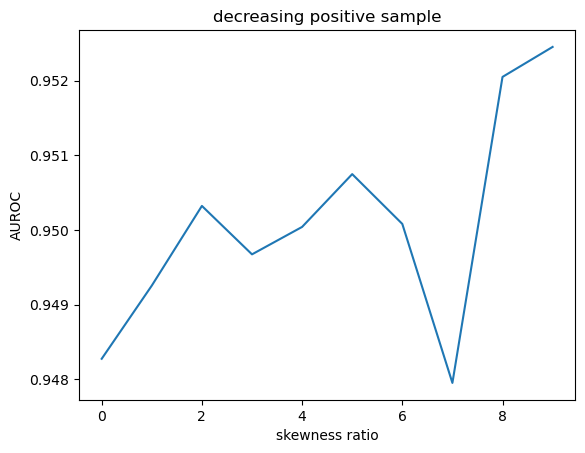

In [5]:
# repeat with different skewness
roc_list = []
lr_acc = []
k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')

  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  lr_auc = roc_auc_score(tmp_testy, lr_probs)

  # summarize scores
  # print('iteration %d: Logistic: ROC AUC=%.3f' % (k, lr_auc))
  k += 1
  # calculate roc curves
  lr_fpr, lr_tpr, _ = roc_curve(tmp_testy, lr_probs)
  roc_list.append(lr_auc)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUROC')
plt.title('decreasing positive sample')


## 질문 1: 데이터 불균형이 심해지는데 AUROC 평가 지표는 왜 높게 형성이 될까요?

## 답변 1
-

AUROC는 TPR(True Positive Rate)과 FPR(False Positive Rate)을 커브로 그린 것입니다.
실습 코드는 Negative는 유지하고 Positive를 줄여나가면서 데이터 불균형을 만들고, 이에 따라 AUROC가 어떻게 변화하는지를 보여줍니다. 

결과를 봤을 때 AUROC는 데이터 뷸균형이 발생해도 높은 값을 유지하고 있는데, 이는 TPR은 TP/(TP+FN), FPR은 FP/(FP+TN) 이기 때문입니다.
실습 1번에서는 Positive 데이터를 줄여가며 Negative가 압도적으로 많아지는 상황을 만들었고, 이 경우 TN의 절대적인 수가 매우 커지게 되어, FP가 일부 발생해도 FPR = FP/(FP+TN)의 분모가 크기 때문에 FPR이 낮게 유지됩니다.

이러한 결과를 봤을 때, AUROC는 데이터 불균형에 둔감한 지표이며, 불균형 데이터에서는 Precision, Recall 등의 지표를 함께 확인해야 합니다.

# 실습 2 : Precision, Recall, F1 Score의 이해


In [6]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [7]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [8]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

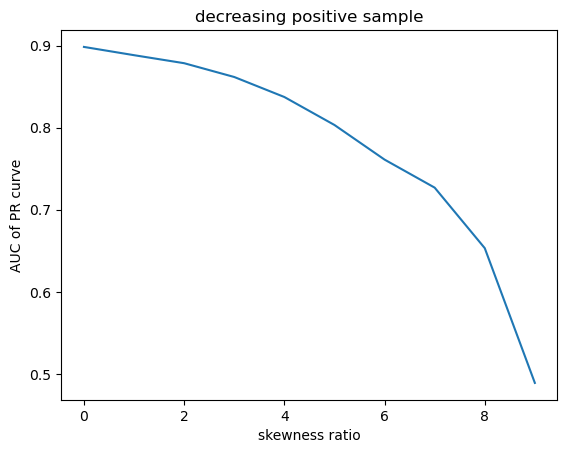

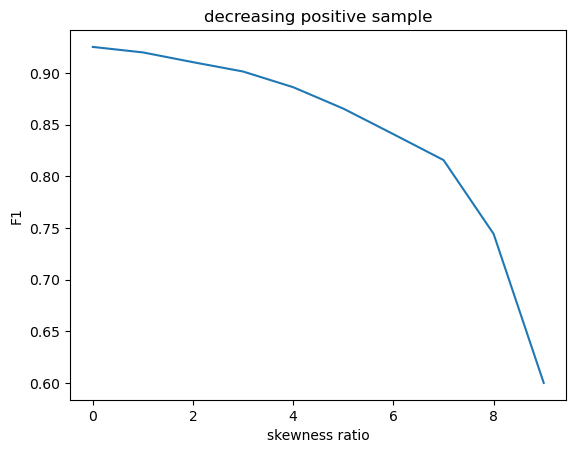

In [9]:
roc_list = []
f1_list = []

k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')


  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # predict class values
  yhat = model.predict(tmp_testX)
  # calculate precision and recall for each threshold
  lr_precision, lr_recall, _ = precision_recall_curve(tmp_testy, lr_probs)
  # calculate scores
  lr_f1, lr_auc = f1_score(tmp_testy, yhat), auc(lr_recall, lr_precision)
  # summarize scores
  # print('iteration%d Logistic: f1=%.3f auc=%.3f' % (k, lr_f1, lr_auc))
  k += 1
  roc_list.append(lr_auc)
  f1_list.append(lr_f1)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUC of PR curve')
plt.title('decreasing positive sample')

plt.figure()
plt.plot(np.arange(0, len(roc_list)), f1_list)
plt.xlabel('skewness ratio')
plt.ylabel('F1')
plt.title('decreasing positive sample')


## 질문 2: AUC, RC Curve와 F1 Curve는 데이터 불균형에 강건한 평가지표인가요? 강건하다면 AUROC보다  강건한 이유를, 그렇지 않다면 강건하지 않은 이유를 설명해주세요.

## 답변 2
-

##

# 실습 3 : Convex Function

In [ ]:
x = np.arange(-2, 2, 0.01)

# 세 개의 함수 중 하나를 선택해서 돌려보세요
# f = lambda x: 0.5 * x ** 2
# f = lambda x: np.cos(np.pi * x)
f = lambda x: -0.5 * x ** 4

filenames=[]
for lamda in np.arange(0, 1, 0.02):
  # LHS
  tmp_x = lamda*x[0] + (1-lamda)*x[-1]

  # RHS
  x_line, y_line = np.array([x[0], x[-1]]), np.array([lamda*f(x[0]), (1-lamda)*f(x[-1])])

  # compute LHS and RHS
  LHS = f(tmp_x)
  RHS = lamda*f(x[0]) + (1-lamda)*f(x[-1])
  if LHS > RHS:
    print('At lamda %0.3f, it is concave' % lamda)
    print('lhs %.5f rhs %.5f' % (LHS, RHS))

  plt.figure()
  # original graph
  plt.plot(x, f(x), label='f(x)')
  # plot RHS
  plt.plot(x_line, y_line, label='%0.3f' % lamda)
  # plot LHS
  plt.scatter(tmp_x, f(tmp_x))
  #title, legennd
  plt.title('lhs %.3f rhs %.3f' % (LHS, RHS))
  plt.legend()
  plt.savefig('lamda %0.3f.png' % lamda)
  # plt.close()
  filenames.append('lamda %0.3f.png' % lamda)

# Build GIF
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## 질문 3-1: 3개의 함수를 확인할 수 있습니다. 3개의 함수중 최적화가 쉬운 함수는 무엇이고, 왜 그 함수가 최적화하기 쉬울까요?

## 답변 3-1:
-

## 질문 3-2: 지역 최적해(local minimum)'와 '전역 최적해(global minimum)'의 차이점과 연관 지어, Non-convex 함수를 최적화할 때 발생할 수 있는 문제점은 무엇인지 설명해주세요.

## 답변 3-2:
-

# 실습 4 : SGD Optimization

In [ ]:
def make_data():
    x1 = random.randint(0, 1)
    x2 = random.randint(0, 1)
    yy = 0 if (x1 == x2) else 1

    # centered at zero
    x1 = 2. * (x1 - 0.5)
    x2 = 2. * (x2 - 0.5)
    yy = 2. * (yy - 0.5)

    # add noise
    x1 += 0.1 * random.random()
    x2 += 0.1 * random.random()
    yy += 0.1 * random.random()

    return [x1, x2, ], yy

def make_batch():
    data = [make_data() for ii in range(batch_size)] # 10, 20, 30 중 택 1
    labels = [label for xx, label in data]
    data = [xx for xx, label in data]
    return np.array(data, dtype='float32'), np.array(labels, dtype='float32')

In [ ]:
train_data = [make_batch() for ii in range(500)]
test_data = [make_batch() for ii in range(50)]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
torch.manual_seed(42)

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.dense1 = nn.Linear(2, 2)
        self.dense2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.tanh(self.dense1(x))
        x = self.dense2(x)
        return torch.squeeze(x)

In [ ]:
# initialize our network
model = NN()

## optimizer = stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr = 0.001)


## train and test functions
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data):
        data, target = Variable(torch.from_numpy(data)), Variable(torch.from_numpy(target))
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} {}\tLoss: {:.4f}'.format(epoch, batch_idx * len(data), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_data:
        data, target = Variable(torch.from_numpy(data), volatile=True), Variable(torch.from_numpy(target))
        output = model(data)
        test_loss += F.mse_loss(output, target)
        correct += (np.around(output.data.numpy()) == np.around(target.data.numpy())).sum()

    test_loss /= len(test_data)
    test_loss = test_loss.item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, batch_size * len(test_data), 100. * correct / (batch_size * len(test_data))) )

In [ ]:
## run experiment
nepochs = 1000
lr = 0.001

print('lr=', lr)
for epoch in range(1, nepochs + 1):
    train(epoch)
    print('---------------------------------------------')
    test()

## 실습 4: lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr = [0,0001, 0.001, 0.01, 0.1]

## 답변 4  
-  

# 실습 5: Sigmoid Function

In [ ]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of weight on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1]) * i * 0.5
  b = np.ones([1, 1]) * 0

  plt.plot(x, f(x, w, b))
  plt.title('w = %0.1f' % i)
  plt.grid()
  plt.savefig('w %0.1f.png' % i)
  plt.close()
  filenames.append('w %0.1f.png' % i)

# Build GIF
with imageio.get_writer('w_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [ ]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of bias on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1])
  b = np.ones([1, 1])* i

  plt.plot(x, f(x, w, b))
  plt.title('b = %0.1f' % i)
  plt.grid()
  plt.savefig('b %0.1f.png' % i)
  plt.close()
  filenames.append('b %0.1f.png' % i)ㅠ

# Build GIF
with imageio.get_writer('b_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# 실습 6: Logistic Regression

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
input_size = 28 * 28  # 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# 2.3.1 Check data
print(train_dataset)
print('----------------')
print(test_dataset)
print()

import matplotlib.pyplot as plt
print('training data shape: ', train_dataset.data.shape)
n = np.random.randint(0, 60000)
plt.imshow(train_dataset.data[n])
plt.title(f'n = %d label = %d' % (n, train_dataset.train_labels[n].numpy()))

In [ ]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

## 코드 구현 6-1 : 아래 log_softmax함수를 구현하세요.

In [ ]:
class custom_CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(custom_CrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        num_examples = targets.shape[0]
        batch_size = inputs.shape[0]
        softmax_outputs = self.log_softmax(inputs)
        outputs = softmax_outputs[range(batch_size), targets]
        return -torch.sum(outputs)/num_examples

    @staticmethod
    def log_softmax(x):
      return ### put the log_softmax function here ###

In [ ]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

## 질문 6 : 다중 분류 문제에서는 왜 sigmoid를 사용하지 못하고 softmax를 사용하게 될까요?

## 답변 6
-